In [1]:
import numpy as np

class Kernel:
    def f(self, x1, x2):
        raise NotImplementedError()
    def f_mat(self, x):
        raise NotImplementedError()

class WhiteNoise(Kernel):
    def __init__(self, scale):
        self.scale = scale
    def f(self, x1, x2):
        return self.scale * (x1 == x2)
    def f_mat(self, x):
        return self.scale * np.eye(len(x))

class Constant(Kernel):
    def __init__(self, value):
        self.value = value
    def f(self, x1, x2):
        return self.value
    def f_mat(self, x):
        n = len(x)
        return self.value * np.ones((n, n))

class Linear(Kernel):
    def __init__(self, intercept):
        self.intercept = intercept
    def f(self, x1, x2):
        return (x1 - self.intercept) * (x2 - self.intercept)
    def f_mat(self, x):
        xs_minus_intercept = np.asarray(x) - self.intercept
        return np.outer(xs_minus_intercept, xs_minus_intercept)

class SquaredExponential(Kernel):
    def __init__(self, scale):
        self.scale = scale
    def f(self, x1, x2):
        return np.exp(-.5 * (x1 - x2) * (x1 - x2) / self.scale)
    def f_mat(self, x):
        dx = np.subtract.outer(x, x)
        return np.exp(-0.5 * dx * dx / self.scale)

class Periodic(Kernel):
    def __init__(self, scale, period):
        self.scale = scale
        self.period = period
    def f(self, x1, x2):
        freq = 2 * np.pi / self.period
        return np.exp((-1. / self.scale) * (np.sin(freq * abs(x1 - x2)))**2)
    def f_mat(self, x):
        freq = 2 * np.pi / self.period
        dx = np.subtract.outer(x, x)
        return np.exp((-1. / self.scale) * (np.sin(freq * abs(dx)))**2)

class Plus(Kernel):
    def __init__(self, K, H):
        self.K = K
        self.H = H
    def f(self, x1, x2):
        return self.K.f(x1, x2) + self.H.f(x1, x2)
    def f_mat(self, x):
        return self.K.f_mat(x) + self.H.f_mat(x)

class Times(Kernel):
    def __init__(self, K, H):
        self.K = K
        self.H = H
    def f(self, x1, x2):
        return self.K.f(x1, x2) * self.H.f(x1, x2)
    def f_mat(self, x):
        return self.K.f_mat(x) * self.H.f_mat(x)

def sigma_cp(x, location, scale):
    return .5 * (1 + np.tanh((location - x) / scale))

class ChangePoint(Kernel):
    def __init__(self, K, H, location, scale):
        self.K = K
        self.H = H
        self.location = location
        self.scale = scale
    def f(self, x1, x2):
        sigma_x1 = sigma_cp(x1, self.location, self.scale)
        sigma_x2 = sigma_cp(x2, self.location, self.scale)
        cov_K = sigma_x1 * self.K.f(x1, x2) * sigma_x2
        cov_H = (1 - sigma_x1) * self.H.f(x1, x2) * (1 - sigma_x2)
        return cov_K + cov_H
    def f_mat(self, x):
        change_x = sigma_cp(x, self.location, self.scale)
        sig_1 = np.outer(change_x, change_x)
        sig_2 = np.outer(1 - change_x, 1 - change_x)
        cov_K = self.K.f_mat(x)
        cov_H = self.H.f_mat(x)
        return sig_1 * cov_K + sig_2 * cov_H

In [2]:
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt

In [3]:
xs = np.linspace(0, 10, 100)

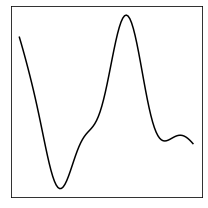

In [4]:
cov = SquaredExponential(1.5)
M = cov.f_mat(xs)
ys = multivariate_normal.rvs(np.zeros(len(xs)), M, size=10)
fig, ax = plt.subplots()
for i in range(1):
    ax.plot(xs, ys[i], color='k', linewidth=1.5)
ax.set_xticks([])
ax.set_yticks([])
fig.set_size_inches(3,3)
fig.set_tight_layout(True)
fig.savefig('/tmp/gp-fig-1.png', dpi=200)

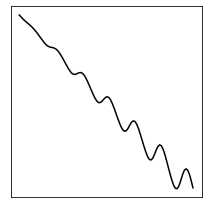

In [5]:
cov = Times(Linear(0.1), Periodic(50, 3))
M = cov.f_mat(xs)
ys = multivariate_normal.rvs(np.zeros(len(xs)), M, size=5)
fig, ax = plt.subplots()
for i in range(1):
    ax.plot(xs, ys[i], color='k', linewidth=1.5)
ax.set_xticks([])
ax.set_yticks([])
fig.set_size_inches(3,3)
fig.set_tight_layout(True)
fig.savefig('/tmp/gp-fig-2.png', dpi=200)

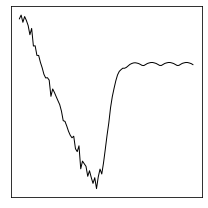

In [6]:
cov = ChangePoint(Plus(Linear(1), WhiteNoise(0.01)), Periodic(10, 2), 5, 0.5)
M = cov.f_mat(xs)
ys = multivariate_normal.rvs(np.zeros(len(xs)), M, size=10)
fig, ax = plt.subplots()
for i in range(1):
    ax.plot(xs, ys[i], color='k', linewidth=1)
ax.set_xticks([])
ax.set_yticks([])
fig.set_size_inches(3,3)
fig.set_tight_layout(True)
fig.savefig('/tmp/gp-fig-3.png', dpi=200)